# Notebook for testing and optimising random forest model


In [25]:
import sys
sys.path.insert(0, '../notebooks')

from Build_ML_df import *
#generate dataframe for ML
ML_df = df_for_ML().merged_structural()

/Applications/anaconda3/envs/Python_3-7/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:434: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to zeros.
  warnings.warn("1 A^3 CRYST1 record,"


In [26]:
df = ML_df[['BINARY_PHENOTYPE', 'MIC', 'Ligand0_Distance', 'Ca_Distance', 
            'cardiolipin_Distance', 'Depth', 'lipid_head_dis', 'lipid_tail_dis',
            'dG_stability', 'd_volume', 'd_MW', 'd_hydropathy', 'Pi', 'MAPP', 
            'H', 'B', 'E', 'G', 'I', 'T', 'S', 'NaN']].copy()
#conver foldx stability values to floats
df['dG_stability'] = df['dG_stability'].astype(float, errors='raise')
df.dropna(inplace=True)

#convert intermediate phenotypes to resistant
List = []
for i in df['BINARY_PHENOTYPE']:
    if i == 'I':
        List.append('R')
    else:
        List.append(i)
        
df['BINARY_PHENOTYPE'] = List

#create numpy array with features for ML training
data_array = df[df.columns[2:]].to_numpy()

#create column with 01 binary phenotype
List = []
for i in df['BINARY_PHENOTYPE']:
    if i == 'R':
        List.append(0)
    else:
        List.append(1)
df['BF'] = List

## Direct binary classification

#### Strategy for finding best performing model:
1) Grid search for best performing preprocessing and parameters for *ACCURACY*      
2) Plot feature importance chart     
3) Grid search for best performing preprocessing and parameters for *average precision*      
4) Grid search for best performing preprocessing and parameters for *ROC AUC       
5) enerate precision-recall curve with best parameters for *average precision*      
6) enerate ROC curve with best parameters for *ROC AUC*          
7) Generate confusion matrix with best parameters for either average preicsion or ROC AUC (these tend to have the same best performing parameters)    

In [27]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

forest = RandomForestClassifier(n_jobs=-1, random_state=0)



param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[2,4,6,8,10,12,14,16]}
X_train, X_test, y_train, y_test = train_test_split(data_array, df['BF'],
                                                    random_state=0)

### 1) Grid search for best performing preprocessing and parameters for ACCURACY

In [28]:
#grid search with shuffled kfold validation
KFold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=KFold_shuffle)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test, grid_kfold_shuffle.predict(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=12, n_estimators=10, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.8640584942185946
grid_kfold_shuffle: test set average accuracy:  0.8766233766233766 



### 2) Generate feature importance plots 

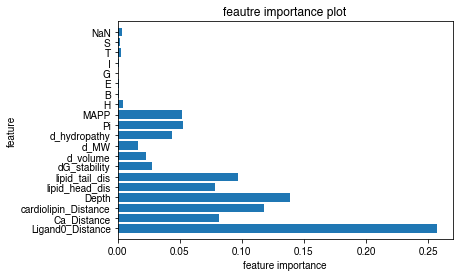

In [29]:
from matplotlib import pyplot as plt
import numpy as np

#define and fit forests with best performing parameters, or default parameters
forest_best_params = RandomForestClassifier(max_depth=8, n_estimators=50, n_jobs=-1, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
forest_best_params.fit(X_train, y_train)    
forest_no_params.fit(X_train, y_train)

#plot charts
def plot_feature_importances(model):
    n_features = data_array.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[2:-1])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('feautre importance plot')

plot_feature_importances(forest_no_params)

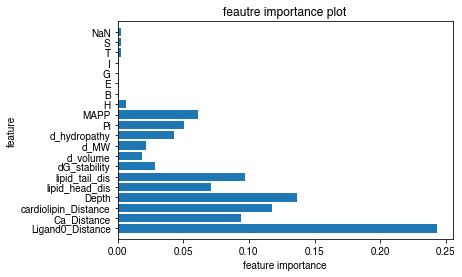

In [30]:
plot_feature_importances(forest_best_params)

### 3) Grid search for best performing parameters for AVERAGE PRECISION SCORE

In [31]:
#grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_estimators=30, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7504219145940337
grid_kfold_shuffle test set average precision:  0.7381772678564286 



### 4) Grid search for best performing preprocessing and parameters for ROC AUC

In [32]:
#grid search with shuffled kfold validation
#use predict_prob a function ot calculate ROC AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test, grid_kfold_shuffle.predict_proba(X_test)[:,1]), '\n')


grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_estimators=20, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.8469022632274452
grid_kfold_shuffle test set AUC:  0.8511448397744107 



### 5) Generate precision-recall curve with best parameters for average precision  

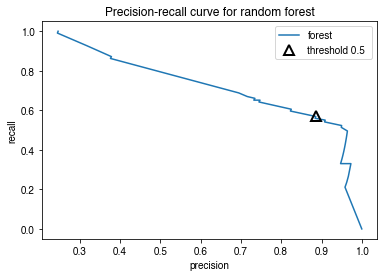

In [33]:
#precision recall curve for best average precision estimator
#max_depth=4, n_estimators=40

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(data_array, df['BF'], random_state=0)
forest = RandomForestClassifier(max_depth=8, n_estimators=30, random_state=0)
forest.fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, forest.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label='forest')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision-recall curve for random forest')
plt.legend(loc='best')


### 6) Generate ROC curve

Text(0.5, 1.0, 'ROC curve for random forest')

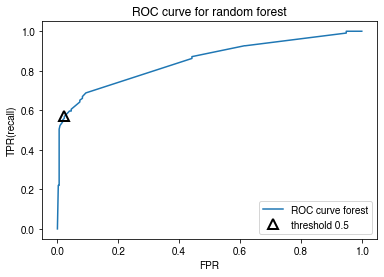

In [34]:
# parameters for best AUC: 
from sklearn.metrics import roc_curve

forest = RandomForestClassifier(max_depth=8, n_estimators=20, random_state=0)
forest.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label='ROC curve forest')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.title('ROC curve for random forest')

### 7) Generate confusion matrix with best parameters for average precision and ROC AUC

### Precision/sens/spec/fpr:

precision = PPV = TP/TP+FP   
sensitivity = recall = TPR = TP/TP+FN   
specificity = TNR = TN/TN+FP   
FPR = FP/FP+TN = (1-specificity)

### Errors:

very major error is a susceptible prediction when isolate is resistant:    
Very major error = (no. very major errors/no. actaul resistant)*100

major error is a resitant prediction when isoalte is susceptible   
major error = (no major erors/no. actual susceptible)*100


In [35]:
#confusion matrix (max_depth=4, n_estimators=40)
#best parameters for average precision

from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data_array, df['BF'], random_state=0)
forest = RandomForestClassifier(max_depth=8, n_estimators=30, random_state=0)
forest.fit(X_train, y_train)
predict = forest.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.8857142857142857
Sensitivity:  0.5688073394495413
Specificity:  0.9773371104815864
FPR : 0.022662889518413554
very major error : 2.26628895184136
major error:  43.11926605504588

 confusion matrix: 
 [[345   8]
 [ 47  62]]


In [36]:
#confusion matrix (max_depth=4, n_estimators=30)
#best parameters for ROC AUC

from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data_array, df['BF'], random_state=0)
forest = RandomForestClassifier(max_depth=8, n_estimators=20, random_state=0)
forest.fit(X_train, y_train)
predict = forest.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.8857142857142857
Sensitivity:  0.5688073394495413
Specificity:  0.9773371104815864
FPR : 0.022662889518413554
very major error : 2.26628895184136
major error:  43.11926605504588

 confusion matrix: 
 [[345   8]
 [ 47  62]]


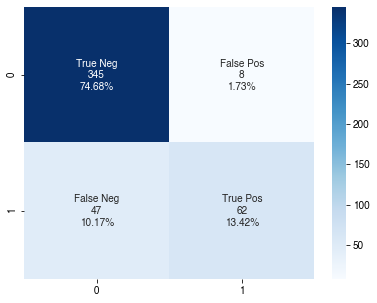

In [37]:
import seaborn as sns
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Helvetica'})

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (6.5,5))
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
plt.savefig('forest_binary_cf.png', bbox_inches='tight')

## Indirect binary classification via multiclass MIC classification with compressed MIC labels

#### Strategy for finding best performing model:
1) Grid search for best performing parameters for *ACCURACY*    
2) Grid search for best performing parameters for *weighted precision*    
3) Grid search for best performing parameters for *weighted recall*    
4) Generate feature importance plot     
5) Generate confusion matrix and classification report     
6) Convert predicted test MIC to binary phenotype and resplit data with same random state for binary y_test          
7) Generate confusion matrix and binary classification report with best parameters for accuracy   

In [38]:
#Compresss MIC labels via the following dictionary

Dict = {'>=32':['>32','32.0'], '16':['16.0'], '8':['>8','8.0'], '4':['4.0'], '2':['2.0'], '1':['1.0'], 
        '0.5':['0.5'], '<=0.25':['0.25','<=0.25','<=0.06']}
List = []
for i in df.index:
     for k,v in Dict.items():
            for j in v:
                if df['MIC'][i]==j:
                    List.append(k)
                    
#add compressed labels to df (not data array)
df['MIC_compressed'] = List

### 1) Grid search for best performing preprocessing and parameters for *ACCURACY* 

In [39]:
#no preprocessing - therefore, no pipeline
#build classifier and parameter grid

forest = RandomForestClassifier(n_jobs=-1, random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60, 100],
              'max_depth':[2,4,6,8,10,12,14,16]}
X_train, X_test, y_train, y_test = train_test_split(data_array, df['MIC_compressed'],
                                                    random_state=0)

In [40]:
#Grid search with kfold cross validation (best cv for logreg multiclass classifcation)
from sklearn.model_selection import KFold
KFold = KFold(n_splits=5)
grid_kfold = GridSearchCV(forest, param_grid, cv=KFold, n_jobs=-1)
grid_kfold.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test, grid_kfold.predict(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=10, n_estimators=60, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.47072149845654787
grid_kfold_shuffle: test set average accuracy:  0.49134199134199136 



### 2) Grid Search for best performing preprocessing and parameters for *weighted precision*

In [41]:
from sklearn.metrics import make_scorer, precision_score

forest = RandomForestClassifier(n_jobs=-1,random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60, 100],
              'max_depth':[2,4,6,8,10,12,14,16]}
scorer = make_scorer(precision_score, average='weighted')

X_train, X_test, y_train, y_test = train_test_split(data_array, df['MIC_compressed'],
                                                    random_state=0)

In [42]:
from sklearn.model_selection import KFold
#Grid search with shuffled kfold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid=param_grid, scoring=scorer, cv=Kfold_shuffle, n_jobs=-1)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set precision score: ', 
       precision_score(y_test, grid_kfold_shuffle.predict(X_test), average='weighted', zero_division=True), '\n')


grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_estimators=60, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.45841134369512543
grid_kfold_shuffle: test set precision score:  0.5157386021482364 



### 3) Grid search for best performing preprocessing and parameters for *weighted recall*

In [43]:
from sklearn.metrics import recall_score

forest = RandomForestClassifier(n_jobs=-1,random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60, 100],
              'max_depth':[2,4,6,8,10,12,14,16]}
scorer = make_scorer(recall_score, average='weighted')

X_train, X_test, y_train, y_test = train_test_split(data_array, df['MIC_compressed'],
                                                    random_state=0)

In [44]:
#Grid search with shuffled kfold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid=param_grid, scoring=scorer, cv=Kfold_shuffle, n_jobs=-1)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set recall score: ', 
       recall_score(y_test, grid_kfold_shuffle.predict(X_test), average='weighted', zero_division=True), '\n')


grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_estimators=40, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.476513367864804
grid_kfold_shuffle: test set recall score:  0.49134199134199136 



### 4) Generate feature importance plots with best params for weighted precision

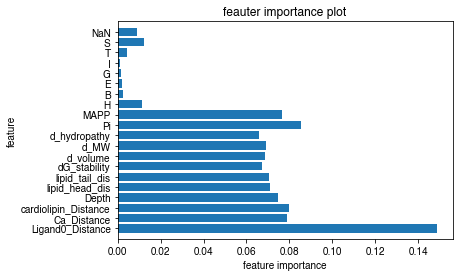

In [45]:
#build classifier and fit with best performing parameters, or default parameters
forest_best_params = RandomForestClassifier(max_depth=8, n_estimators=60, n_jobs=-1, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
forest_best_params.fit(X_train, y_train)    
forest_no_params.fit(X_train, y_train)

#plot charts
def plot_feature_importances(model):
    n_features = data_array.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[2:-2])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('feauter importance plot')

plot_feature_importances(forest_no_params)

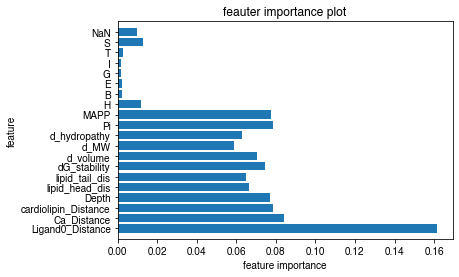

In [46]:
plot_feature_importances(forest_best_params)

### 5) Generate multiclass confusion matrix and classification report using best accuracy estimator

In [47]:
compressed_int_dict, compressed_int = {'>=32':'32', '<=0.25':'0.25'}, []
for i in df['MIC_compressed']:
    if i in compressed_int_dict.keys():
        for k,v in compressed_int_dict.items():
            if k == i:
                compressed_int.append(v)
    else:
        compressed_int.append(i)

            
X_train, X_test, y_train, y_test = train_test_split(data_array, compressed_int, random_state=0)



#copy and fit classifier with best parameters from previous section
forest = forest_best_params
forest.fit(X_train, y_train)                 
                 
predict = forest.predict(X_test)
#generate confusion matrix
confusion = confusion_matrix(y_test, predict, labels=['0.25','0.5','1','2','4','8','16','32'])

print ('\n confusion matrix: \n', confusion)


 confusion matrix: 
 [[  0   1   1   0   3   1   0   0]
 [  0   2   6   1   1   2   0   0]
 [  0   8  18   6   5   7   0   0]
 [  0   1   7   9  25   4   0   1]
 [  0   0   1   3  80  44   0   0]
 [  0   0   1   1  59 119   0   0]
 [  0   0   0   0   7  22   0   0]
 [  0   0   0   0   2  14   0   0]]


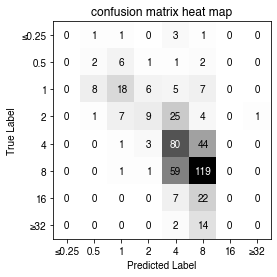

In [48]:
#generate heatmap of confusion matrix for visualisation

import mglearn

#this order of the target names is crucial
target_names = ['≤0.25', '0.5', '1', '2', '4', '8', '16', '≥32']
scores_image = mglearn.tools.heatmap(confusion, xlabel='Predicted Label',
                                     ylabel='True Label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix heat map')
plt.gca().invert_yaxis()
plt.savefig('RF_multi_expand_cf.png', bbox_inches='tight')

In [49]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test, predict, zero_division=True))

              precision    recall  f1-score   support

        0.25       1.00      0.00      0.00         6
         0.5       0.17      0.17      0.17        12
           1       0.53      0.41      0.46        44
          16       1.00      0.00      0.00        29
           2       0.45      0.19      0.27        47
          32       0.00      0.00      0.00        16
           4       0.44      0.62      0.52       128
           8       0.56      0.66      0.61       180

    accuracy                           0.49       462
   macro avg       0.52      0.26      0.25       462
weighted avg       0.52      0.49      0.45       462



### 6) Convert predicted test MIC to binary phenotype and resplit data with same random state for binary y_test 

In [50]:
def MIC_to_binary(Predict):
    RS_dict = {1:['0.25', '0.5', '1', '2'],
           0:['4', '8', '16', '32']}
    binary_list = []
    for i in predict:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

#resplit data
X_train, X_test, y_train, y_test = train_test_split(data_array, df['BF'],
                                                  random_state=0)

In [51]:
List = ['0.25', '0.5', '1', '2', '4', '8', '16', '32']
for i in predict:
    if i not in List:
        print (i)


### 7) Generate confusion matrix and classification report with best parameters for accuracy

In [52]:
#generate confusion matrix
confusion = confusion_matrix(y_test, MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)
                

Precision:  0.9090909090909091
Sensitivity:  0.5504587155963303
Specificity:  0.9830028328611898
FPR : 0.016997167138810165
very major error : 1.69971671388102
major error:  44.95412844036697

 confusion matrix: 
 [[347   6]
 [ 49  60]]


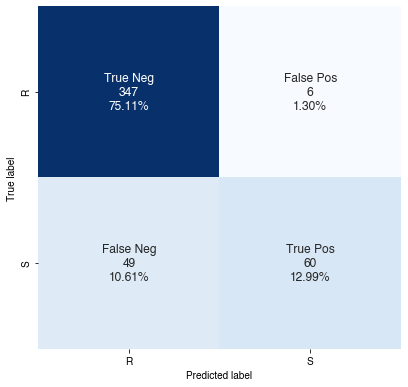

In [53]:
import seaborn as sns
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Helvetica'})

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (6.5,6.3))
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues', 
            xticklabels=['R','S'], yticklabels=['R','S'], annot_kws={'size':'large'},cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('forest_mutliclass_binary_cf.png', bbox_inches='tight')